# Week 2 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [ ]:
corpus_name = "/Users/bhargavvader/Downloads/Academics_Tech/" 
# corpus_name = "Movies"

Just to be clear, your corpus_name should be different since you're not bhargav. Modify the corpus_name with your directory. This method extracts the text from the zip files and stroes the raw data.

In [ ]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [ ]:
movie_raw = loadcorpus(corpus_name)

In [ ]:
movie_raw['11.txt'][0:3]

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [ ]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [ ]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [ ]:
clean_11[1]

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [20]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [21]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [22]:
word_tokenize(clean_11[1])

NameError: name 'clean_11' is not defined

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [23]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [ ]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [ ]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

In [ ]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [ ]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

What we are interested in here is the `'contents_url'`

In [ ]:
print(senateReleasesData['contents_url'])

We can use this to get any or all of the files from the repo.

In [ ]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [ ]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [ ]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [24]:
import nltk

In [ ]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [ ]:
whText.common_contexts(['stem'])

We can also just count the number of times the word occurs.

In [ ]:
whText.count('cell')


We can also plot each time a set of words occurs.

In [ ]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [38]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,name,text,path,html_url,download_url
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


If you are having trouble downloading the data uncomment this next cell

In [41]:
whReleases.shape

(10, 7)

In [37]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [42]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [43]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

I downloaded this corpus, called BillSum, from https://github.com/FiscalNote/BillSum. It contains 24% of total Congressional bills from 1993-2016.

In [2]:
corpus_name = '/Users/lilygrier/Documents/Grad_School/Computational Content Analysis/billsum_v4_1/us_train_data_final_OFFICIAL.jsonl'

In [6]:
bills = pd.read_json(corpus_name, lines=True)

In [31]:
bills.iloc[0].text

"SECTION 1. SHORT TITLE.\n\n    This Act may be cited as the ``Border Hospital Survival and Illegal \nImmigrant Care Act''.\n\nSEC. 2. FINDINGS.\n\n    The Congress finds as follows:\n            (1) Immigration is a Federal responsibility.\n            (2) The Immigration and Naturalization Service does not \n        take into custody all aliens who are unlawfully present in the \n        United States.\n            (3) Section 1867 of the Social Security Act (42 U.S.C. \n        1395dd) and State laws require that, if any individual (whether \n        or not lawfully present in the United States) comes to a \n        hospital and the hospital determines that the individual has an \n        emergency medical condition, the hospital must provide either, \n        within the staff and facilities available at the hospital, for \n        such further medical examination and such treatment as may be \n        required to stabilize the medical condition, or, if \n        appropriate, for tr

In [46]:
#bills['tokenized_text'] = bills['text'].apply(lambda x: word_tokenize(x))

I'm going to look only at bills whose text mentions the word "climate." This is about 250 bills. Adding the word "energy" yields a corpus of 1400 bills. For the sake of computational feasibility, I limit my dataset to the smaller dataset found with the climate keyword.

In [50]:
climate_bills = bills[bills['text'].str.contains('climate')]

In [57]:
clim_bills = bills[bills['text'].str.contains('climate|energy')]

In [98]:
#clim_bills

The first bill containing the word climate is the green energy bill of 2009.

In [93]:
climate_bills.loc[:, 'tokenized_text'] = climate_bills['text'].apply(lambda x: word_tokenize(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [115]:
climate_bills['word_counts'] = climate_bills['tokenized_text'].apply(lambda x: len(x))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [116]:
climate_bills

,bill_id,text,summary,title,text_len,sum_len,tokenized_text,word_counts
130,111_s137,SECTION 1. SHORT TITLE.\n\n This Act may be...,Green Energy Production Act of 2009 - Establis...,A bill to create jobs and reduce the dependenc...,16335,712,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1992
155,114_hr2485,SECTION 1. SHORT TITLE.\n\n This Act may be...,Regional Infrastructure Accelerator Act of 201...,Regional Infrastructure Accelerator Act of 2015,16139,2579,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1796
230,112_hr910,SECTION 1. SHORT TITLE.\n\n This Act may be...,Energy Tax Prevention Act of 2011 - Amends the...,To amend the Clean Air Act to prohibit the Adm...,11484,4322,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1344
231,114_hr3140,SECTION 1. SHORT TITLE.\n\n This Act may be...,Accounting for Methane in Production through L...,AMPLE Oil and Gas Royalties Act,6172,955,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",856
288,110_s3624,SECTION 1. SHORT TITLE.\n\n This Act may be...,"Clean, Low-Emission, Affordable, New Transport...","A bill to amend title 49, United States Code, ...",16376,1416,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",2238
...,...,...,...,...,...,...,...,...
18819,105_s2431,SECTION 1. SHORT TITLE.\n\n This Act may be...,Torture Survivors Relief Act of 1998 - Amends ...,Torture Survivors Relief Act of 1998,8983,2125,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1236
18824,111_s810,SECTION 1. SHORT TITLE.\n\n This Act may be...,Ocean and Coastal Adaptation Planning Act - Di...,A bill to establish 4 regional institutes as c...,6227,990,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",749
18878,110_hr5970,SECTION 1. SHORT TITLE.\n\n This Act may be...,Belarus Democracy Reauthorization Act of 2008 ...,To amend the Belarus Democracy Act of 2004 to ...,8543,639,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1048
18881,113_hr1943,SECTION 1. SHORT TITLE.\n\n This Act may be...,Super Pollutant Emissions Reduction Act of 201...,SUPER Act of 2013,8607,1136,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1024


In [117]:
clim_bills

,bill_id,text,summary,title,text_len,sum_len
9,111_hr5674,SECTION 1. SHORT TITLE.\n\n This Act may be...,Mercury Reduction and Energy Security Act of 2...,To amend the Clean Air Act to require reductio...,14471,1638
47,114_hr1145,SECTION 1. SHORT TITLE.\n\n This Act may be...,Biomass Thermal Utilization Act of 2015 or the...,BTU Act of 2015,5321,763
50,111_hr3033,SECTION 1. SHORT TITLE.\n\n This Act may be...,Carbon Neutral Government Act of 2009 - Author...,To authorize Federal agencies and legislative ...,5099,857
79,114_hr5797,SECTION 1. SHORT TITLE.\n\n This Act may be...,California Seamounts and Ridges National Marin...,California Seamounts and Ridges National Marin...,12272,949
82,113_hr5775,"SECTION 1. SHORT TITLE, ETC.\n\n (a) Short ...",Powering American Jobs Act of 2014 - Amends th...,Powering American Jobs Act of 2014,13923,692
...,...,...,...,...,...,...
18881,113_hr1943,SECTION 1. SHORT TITLE.\n\n This Act may be...,Super Pollutant Emissions Reduction Act of 201...,SUPER Act of 2013,8607,1136
18899,105_s1606,SECTION 1. SHORT TITLE.\n\n This Act may be...,Torture Victims Relief Act - Prohibits the Uni...,Torture Victims Relief Act,16438,2339
18904,115_hr1567,SECTION 1. SHORT TITLE.\n\n This Act may be...,United States-Mexico Economic Partnership Act ...,United States-Mexico Economic Partnership Act,6664,1743
18925,105_hr4756,SECTION 1. SHORT TITLE.\n\n This Act may be...,Year 2000 Preparedness Act of 1998 - Directs t...,Year 2000 Preparedness Act of 1998,10786,2872


In [125]:
clim_bills['tokenized_text'] = clim_bills['text'].apply(lambda x: word_tokenize(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [126]:
clim_bills

,bill_id,text,summary,title,text_len,sum_len,tokenized_text
9,111_hr5674,SECTION 1. SHORT TITLE.\n\n This Act may be...,Mercury Reduction and Energy Security Act of 2...,To amend the Clean Air Act to require reductio...,14471,1638,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,..."
47,114_hr1145,SECTION 1. SHORT TITLE.\n\n This Act may be...,Biomass Thermal Utilization Act of 2015 or the...,BTU Act of 2015,5321,763,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,..."
50,111_hr3033,SECTION 1. SHORT TITLE.\n\n This Act may be...,Carbon Neutral Government Act of 2009 - Author...,To authorize Federal agencies and legislative ...,5099,857,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,..."
79,114_hr5797,SECTION 1. SHORT TITLE.\n\n This Act may be...,California Seamounts and Ridges National Marin...,California Seamounts and Ridges National Marin...,12272,949,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,..."
82,113_hr5775,"SECTION 1. SHORT TITLE, ETC.\n\n (a) Short ...",Powering American Jobs Act of 2014 - Amends th...,Powering American Jobs Act of 2014,13923,692,"[SECTION, 1, SHORT, TITLE, ETC, a, Short, Titl..."
...,...,...,...,...,...,...,...
18881,113_hr1943,SECTION 1. SHORT TITLE.\n\n This Act may be...,Super Pollutant Emissions Reduction Act of 201...,SUPER Act of 2013,8607,1136,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,..."
18899,105_s1606,SECTION 1. SHORT TITLE.\n\n This Act may be...,Torture Victims Relief Act - Prohibits the Uni...,Torture Victims Relief Act,16438,2339,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,..."
18904,115_hr1567,SECTION 1. SHORT TITLE.\n\n This Act may be...,United States-Mexico Economic Partnership Act ...,United States-Mexico Economic Partnership Act,6664,1743,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,..."
18925,105_hr4756,SECTION 1. SHORT TITLE.\n\n This Act may be...,Year 2000 Preparedness Act of 1998 - Directs t...,Year 2000 Preparedness Act of 1998,10786,2872,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,..."


Bill ID of green energy act is 111_s137

In [62]:
green_energy = climate_bills.iloc[0].text

In [63]:
green_energy_tokens = word_tokenize(green_energy)

In [102]:
countedWords = wordCounter(green_energy_tokens)


In [113]:
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:30]

,word,count
10,the,124
15,of,86
28,and,73
20,to,65
36,a,49
27,in,45
11,`,30
45,for,30
177,corporation,29
5,act,25


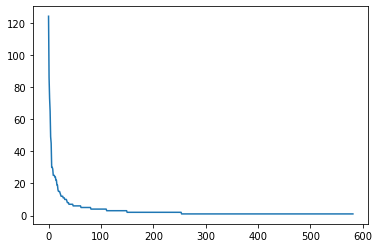

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

These few words make up a lot of the bill.

A simple word count shows lots of stop words. I will filter these out in the next section.

In [64]:
green_energy_text = nltk.Text(green_energy_tokens)

In [75]:
greenIndex = nltk.text.ConcordanceIndex(green_energy_text) 

In [83]:
greenIndex.print_concordance('energy')

Displaying 19 of 19 matches:
ted States the world leader in green energy production and manufacturing by-- 1 
sisting in the transition to a green energy economy and 3 increasing scientific 
g term sustained production of green energy 3 Green energy.-- A In general.--The
-- A In general.--The term ` ` green energy has the meaning given the term ` ` r
meaning given the term ` ` renewable energy B Inclusion.--The term ` ` green ene
rgy B Inclusion.--The term ` ` green energy includes energy derived from coal pr
--The term ` ` green energy includes energy derived from coal produced in a mann
able energy.--The term ` ` renewable energy means electric energy generated at a
 ` ` renewable energy means electric energy generated at a facility including a 
 fuel cells biomass geothermal ocean energy or landfill gas 6 Secretary.--The te
ces and demonstrate commercial green energy production SEC 7 GREEN ENERGY TECHNO
 Corporation shall establish a green energy technology internship program under 

In [84]:
green_energy_text.common_contexts(['energy'])

green_technology green_production green_economy green_3 green_has
renewable_b green_includes includes_derived renewable_means
electric_generated ocean_or of_7 of_a of_5 renewable_carbon
green_projects


In [89]:
green_energy_text.count('energy')

19

In [90]:
green_energy_text.count('renewable')

4

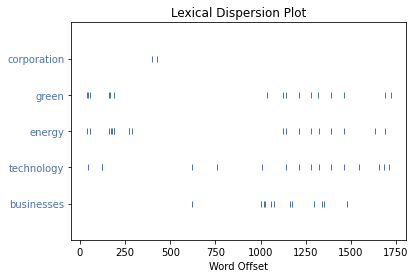

In [114]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
green_energy_text.dispersion_plot(['corporation', 'green', 
                                   'energy', 'technology', 'businesses'])
sns.set()

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [ ]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [ ]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [120]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [ ]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [ ]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

From this we can lookup the distributions of different word lengths

In [ ]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [ ]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [164]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [ ]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [ ]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [ ]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [ ]:
whcfdist_POStoWord['JJ']

Or look at the most common nouns

In [ ]:
whcfdist_POStoWord['NN'].most_common(5)

Or plot the base form verbs against their number of occurrences

In [ ]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [ ]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [118]:

countsDict = {}
for word in climate_bills['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 28681),
 ('of', 21671),
 ('and', 19662),
 ('`', 13090),
 ('to', 11844),
 ('in', 7908),
 ('a', 6294),
 ('for', 5114),
 ('or', 4296),
 ('by', 3507),
 ('shall', 3432),
 ('that', 3027),
 ('Act', 2875),
 ('1', 2848),
 ('as', 2750),
 ('be', 2723),
 ('with', 2620),
 ('2', 2594),
 ('this', 2543),
 ('under', 2471)]

In [127]:
## BELOW IS WITH BIGGER DATASET

In [130]:
countsDict = {}
for word in clim_bills['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_big = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts_big[:20]

[('the', 136307),
 ('of', 102500),
 ('`', 78067),
 ('and', 71203),
 ('to', 50905),
 ('in', 34707),
 ('a', 33294),
 ('or', 25291),
 ('for', 24985),
 ('by', 21285),
 ('shall', 18748),
 ('this', 14995),
 ('under', 14928),
 ('section', 14506),
 ('1', 14058),
 ('be', 14054),
 ('as', 14018),
 ('is', 13898),
 ('Act', 13746),
 ('that', 13684)]

In [131]:
word_counts_big[:50]

[('the', 136307),
 ('of', 102500),
 ('`', 78067),
 ('and', 71203),
 ('to', 50905),
 ('in', 34707),
 ('a', 33294),
 ('or', 25291),
 ('for', 24985),
 ('by', 21285),
 ('shall', 18748),
 ('this', 14995),
 ('under', 14928),
 ('section', 14506),
 ('1', 14058),
 ('be', 14054),
 ('as', 14018),
 ('is', 13898),
 ('Act', 13746),
 ('that', 13684),
 ('2', 12005),
 ('such', 11920),
 ('Secretary', 11307),
 ('with', 11042),
 ('on', 10443),
 ('any', 9441),
 ('energy', 8319),
 ('States', 8182),
 ('A', 8119),
 ('an', 8117),
 ('subsection', 7761),
 ('3', 7624),
 ('United', 7569),
 ('B', 6925),
 ('not', 6873),
 ('SEC', 6779),
 ('other', 6483),
 ('may', 6415),
 ('at', 6397),
 ('term', 6156),
 ('Federal', 5899),
 ('which', 5756),
 ('paragraph', 5690),
 ('State', 5651),
 ('year', 5574),
 ('The', 5463),
 ('In', 5328),
 ('after', 5281),
 ('from', 5165),
 ('than', 5156)]

In [134]:
clim_bills['word_counts'] = clim_bills['tokenized_text'].apply(lambda x: len(x))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


From the above frequencies, the first word that contains any real information is 'energy,' so we will count everything that occurs more frequently than 'energy' as a stop word.

In [132]:
stop_words_freq = []
for word, count in word_counts_big:
    if word == 'energy':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the',
 'of',
 '`',
 'and',
 'to',
 'in',
 'a',
 'or',
 'for',
 'by',
 'shall',
 'this',
 'under',
 'section',
 '1',
 'be',
 'as',
 'is',
 'Act',
 'that',
 '2',
 'such',
 'Secretary',
 'with',
 'on',
 'any']

In [135]:
clim_bills['normalized_tokens'] = clim_bills['tokenized_text'].apply(lambda x: normalizeTokens(x, extra_stop=stop_words_freq))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
clim_bills.loc[:, 'normalized_tokens_count'] = clim_bills['normalized_tokens'].apply(lambda x: len(x))


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [141]:
clim_bills_cfdist = nltk.ConditionalFreqDist(((len(w), w) for w in clim_bills['normalized_tokens'].sum()))


In [143]:
# print the number of words
print('This corpus has ', clim_bills_cfdist.N(), 'unique words')

This corpus has  1103825 unique words


In [155]:
clim_bills_cfdist[5]

FreqDist({'state': 7332, 'u.s.c': 4168, 'title': 3700, 'water': 3682, 'amend': 3598, 'grant': 3489, 'carry': 3331, 'local': 2274, 'later': 2067, 'power': 1977, ...})

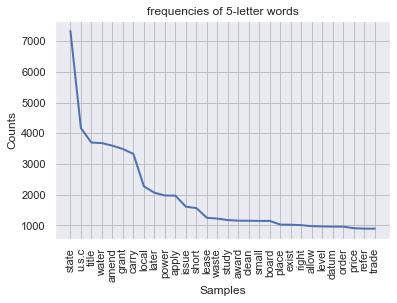

<AxesSubplot:title={'center':'frequencies of 5-letter words'}, xlabel='Samples', ylabel='Counts'>

In [194]:
clim_bills_cfdist[5].plot(30, title='frequencies of 5-letter words')

In [159]:
clim_bills_cpdist = nltk.ConditionalProbDist(clim_bills_cfdist, nltk.ELEProbDist)
print(clim_bills_cpdist[13].max())
print(clim_bills_cpdist[13].prob(clim_bills_cpdist[13].max()))

administrator
0.09575870671994482


The word administrator is the most common 13-letter word and occurs with a probability of 0.0958.

In [160]:
clim_bills_cpdist[13].plot('probability word distributions, 13 letters')

AttributeError: 'ELEProbDist' object has no attribute 'plot'

In [163]:
# NEED TO PLOT THE PROBABILITY DISTRIBUTION ABOVE

In [165]:
# using spacy_pos function defined above
clim_bills['normalized_tokens_POS'] = [spacy_pos(t) for t in clim_bills['text']]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [166]:
# give frequency of each part of speech for each word
clim_bills_cfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in clim_bills['normalized_tokens_POS'].sum())


In [169]:
# look at most common superlative adjectives
clim_bills_cfdist_POStoWord['JJ'].most_common(10)


[('such', 12053),
 ('other', 6920),
 ('federal', 5117),
 ('public', 2941),
 ('fiscal', 2924),
 ('new', 2570),
 ('national', 2376),
 ('local', 2250),
 ('available', 2218),
 ('renewable', 2115)]

In [188]:
# most common verbs
clim_bills_cfdist_POStoWord['VB'].most_common(20)


[('be', 14091),
 ('provide', 2243),
 ('carry', 1869),
 ('apply', 1447),
 ('establish', 1307),
 ('submit', 1253),
 ('make', 1144),
 ('ensure', 1116),
 ('include', 1054),
 ('develop', 903),
 ('use', 814),
 ('have', 736),
 ('reduce', 714),
 ('improve', 683),
 ('exceed', 632),
 ('support', 608),
 ('conduct', 600),
 ('take', 587),
 ('meet', 568),
 ('promote', 564)]

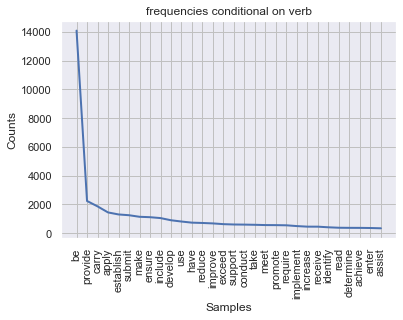

<AxesSubplot:title={'center':'frequencies conditional on verb'}, xlabel='Samples', ylabel='Counts'>

In [192]:
clim_bills_cfdist_POStoWord['VB'].plot(30, title='frequencies conditional on verb')

In [187]:
clim_bills_cfdist_POStoWord['JJ'].most_common(20)

[('such', 12053),
 ('other', 6920),
 ('federal', 5117),
 ('public', 2941),
 ('fiscal', 2924),
 ('new', 2570),
 ('national', 2376),
 ('local', 2250),
 ('available', 2218),
 ('renewable', 2115),
 ('qualified', 2047),
 ('eligible', 2039),
 ('appropriate', 1831),
 ('environmental', 1827),
 ('electric', 1790),
 ('taxable', 1742),
 ('necessary', 1719),
 ('short', 1509),
 ('economic', 1470),
 ('natural', 1422)]

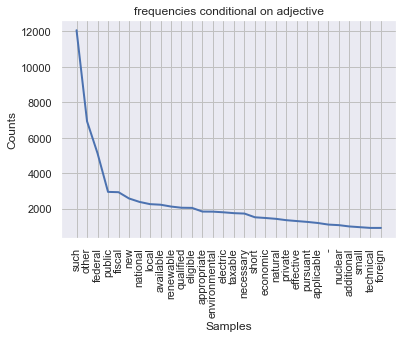

<AxesSubplot:title={'center':'frequencies conditional on adjective'}, xlabel='Samples', ylabel='Counts'>

In [191]:
clim_bills_cfdist_POStoWord['JJ'].plot(30, title='frequencies conditional on adjective')

(-0.5, 499.5, 499.5, -0.5)

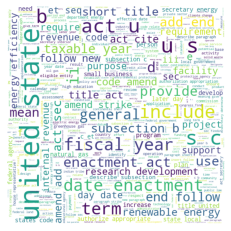

In [196]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(clim_bills['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")

From the above plots we see the most frequent verbs seems to have an aspirational quality to them (e.g., improve, reduce, ensure, etc.). The most frequent adjectives seem to be more concerned with adminsitrative matters (e.g., available, federal, eligible). The word shows many single letters (b, u, s) that have been mistakenly tokenized, but aside from that, reveals a lot of administrative language concerned with logistics such as fiscale year, date of enactment, and taxes. The only explicitly climate-related words that stand out are renewable energy and energy efficiency. This bills obviously outline specific measures to be carried out on specific dates, so the emphasis on logistics makes sense, but I'd be curious to see what linguistically separates climate-related bills from other types of bills.

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [ ]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[0:20]

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [ ]:
movie_texts = {}

In [ ]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [ ]:
import pandas as pd

In [ ]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [ ]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [ ]:
movie_df.head()

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [200]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [201]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [199]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [202]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [203]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>], [$, Me, Hello, IT], [>], [$, Usr, Hi, I,..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [204]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [205]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [206]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, RB), (post, NN), (in, IN), (quite, P...
7    [[(Original, JJ), (Post](https://www.reddit.co...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NNP), (1](http://www.reddit.com, NNP)...
1    [[(>, XX)], [($, $), (Me, PRP), (Hello, UH), (...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [207]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('time', 14),
 ('Usr', 14),
 ('m', 13),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7),
 ('job', 7)]

What about the adjectives that modify the word, "computer"?

In [208]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

Here, we work with a random subset of 5 energy-related bills.

In [220]:
small_df = clim_bills.sample(n=5)

In [242]:
small_df['sentences'] = small_df['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
small_df.index = range(len(small_df) - 1, -1,-1) #Reindex to make things nice in the future
small_df

,bill_id,text,summary,title,text_len,sum_len,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences
4,107_s193,SECTION 1. SHORT TITLE.\n\n This Act may be...,Department of Energy Advanced Scientific Compu...,A bill to authorize funding for Advanced Scien...,10060,953,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1288,"[short, title, act, cite, department, energy, ...",735,"[(section, NN), (1, CD), (., .), (short, JJ), ...","[[SECTION, 1], [SHORT, TITLE], [This, Act, may..."
3,115_s1409,SECTION 1. SHORT TITLE.\n\n This Act may be...,Technologies for Energy Jobs and Security Act ...,Technologies for Energy Jobs and Security Act ...,7870,1516,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1062,"[short, title, act, cite, technology, energy, ...",499,"[(section, NN), (1, CD), (., .), (short, JJ), ...","[[SECTION, 1], [SHORT, TITLE], [This, Act, may..."
2,108_hr1777,SECTION 1. DEFINITIONS.\n\n In this Act:\n ...,Instructs the Secretary of Energy to transmit ...,To provide for the establishment at the Depart...,19212,1223,"[SECTION, 1, DEFINITIONS, In, this, Act, 1, Th...",2310,"[definition, act, term, advisory, committee, m...",1261,"[(section, NN), (1, CD), (., .), (definitions,...","[[SECTION, 1], [DEFINITIONS], [In, this, Act, ..."
1,115_hr1837,SECTION 1. SHORT TITLE.\n\n This Act may be...,st Century Energy Workforce Act This bill dire...,21st Century Energy Workforce Act,9992,998,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",1268,"[short, title, act, cite, 21st, century, energ...",681,"[(section, NN), (1, CD), (., .), (short, JJ), ...","[[SECTION, 1], [SHORT, TITLE], [This, Act, may..."
0,113_s363,SECTION 1. SHORT TITLE.\n\n This Act may be...,This measure has not been amended since it was...,Geothermal Production Expansion Act of 2013,9024,1082,"[SECTION, 1, SHORT, TITLE, This, Act, may, be,...",851,"[short, title, act, cite, geothermal, producti...",429,"[(section, NN), (1, CD), (., .), (short, JJ), ...","[[SECTION, 1], [SHORT, TITLE], [This, Act, may..."


In [243]:
small_df['POS_sents'] = small_df['sentences'].apply(lambda x: tag_sents_pos(x))


In [225]:
# count the number of nouns
countTarget = 'NN'
targetCounts = {}
for entry in small_df['normalized_tokens_POS']:
    #for sentence in entry:
    for ent, kind in entry:
        if kind != countTarget:
            continue
        elif ent in targetCounts:
            targetCounts[ent] += 1
        else:
            targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('energy', 57),
 ('secretary', 53),
 ('section', 47),
 ('hydrogen', 40),
 ('act', 37),
 ('program', 37),
 ('fuel', 34),
 ('year', 33),
 ('term', 24),
 ('education', 23),
 ('computing', 22),
 ('b', 21),
 ('property', 21),
 ('c', 20),
 ('paragraph', 20),
 ('i', 19),
 ('industry', 16),
 ('cell', 13),
 ('heat', 13),
 ('training', 13)]

In [245]:
# Now let's look at adjectives that modify the word 'energy.'
NTarget = 'JJ'
Word = 'energy'
NResults = set()
for entry in small_df['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'applied', 'clean', 'nuclear', 'high', 'relevant', 'diverse', 'renewable', 'introductory', 'domestic', 'other'}


In [253]:
# now let's look at nouns directly modified by 'economic'
NTarget = 'NN'
Word = 'economic'
NResults = set()
for entry in small_df['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind2,ent1.lower())==(NTarget,Word):
                NResults.add(ent2)
            else:
                continue

print(NResults)

{'refueling', 'storage'}


The most common nouns in this subset suggest very concrete plans, as would be expected of an energy bill. Adjectives that directly proceed the word "energy" seemed to be in line with policies fighting climate change (e.g., clean energy, renewable energy). However, 'nuclear energy' was also mentioned, and I'd be interested to see what the relevant bill's stance is on nuclear energy. Given that the economy is often used as a justification for bills, I looked at nouns following economic and was surprised to see 'refueling,' which is itself an energy-related word (perhaps the lawmaker was trying to make a pun--or appeal to those who fear a shift away from fossil fuels will deplete the economy).

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [ ]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [255]:
def bigramScoring(count, wordsTuple, total):
    return count

#print(whBigrams.nbest(bigramScoring, 10))

One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [ ]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

There are a few other available measures

In [ ]:
[s for s in dir(bigram_measures) if s[0] != '_']

We can also look at trigrams

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

Or n-grams (for any number n)

In [ ]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [ ]:
import gensim

In [ ]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [ ]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [ ]:
texts[0]

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [ ]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [ ]:
for token in sent:
    print(token.text, token.ent_type_)

For only finding ents-

In [ ]:
for ent in sent.ents:
    print(ent.text, ent.label_)

In [ ]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [ ]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [ ]:
redditTopScores['classified_sents']

Find the most common entities (which are, of course, boring):

In [ ]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

Or those occurring only twice:

In [ ]:
[x[0] for x in sortedEntities if x[1] == 2]

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [ ]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

What about the Organizations?

In [ ]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [ ]:
from spacy import displacy

In [ ]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [ ]:
displacy.render(doc, style='dep')

In [ ]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [ ]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [ ]:
from spacy.symbols import nsubj, VERB

In [ ]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

You can *also* navigate from above. It isn't as efficient though.

In [ ]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [ ]:
print(verbs)

### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [ ]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [ ]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [ ]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

In [ ]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [ ]:
movie_violences = {}

In [ ]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [ ]:
movie_violences

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [ ]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [ ]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [ ]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [ ]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [ ]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [ ]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

In [ ]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [ ]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [ ]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [ ]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [ ]:
len(corpora)

In [ ]:
fileids = list(movie_df['Movie Name'])[0:11]

In [ ]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

In [ ]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

In [ ]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

In [ ]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [ ]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [ ]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

In [ ]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 